<center> <h1> <span style="color:black"> IA|BE Data Science Certificate - Module 2 - Computer lab 3  </h1> </center> 
<center> <h2> <span style="color:red"> Stochastic gradient boosting machines with XGboost </h1> </center>

## 1. Introduction

Similarly to bagging, boosting is a general technique to create an ensemble of any type of base learner.
In the case of boosting:
* base learners are weak learners (e.g. decision trees), therefore have low variance but high bias
* bias reduction is obtained by updating each fit sequentially
    * current tree uses information from all past trees
    * high performance is obtained by rectifying past mistakes
    * high risk of overfitting.

The base learner can be any type of weak learner. We will use decision trees as weak learners, but linear models could be used as well. The general terminology for tree-based boosting is often called a stochastic gradient boosting machine:
* the algorithm is stochastic by subsampling in the rows (and columns) of the data
* the loss function is optimized via a gradient descent search.

### 1.1 Stochastic gradient descent

<figure>
<img src="https://katrienantonio.github.io/IABE-DS-module-2/img/learning_rate.png" alt="autoencoder_schema" style="width: 800px;"/>
<figcaption><center>Figure 12.4 from Boehmke & Greenwell <a href="https://bradleyboehmke.github.io/HOML/gbm.html">Hands-on with machine learning with R</a>.<p></p></center></figcaption>
</figure>

The selection of the appropriate learning rate is crucial to properly optimize the loss function:
* if too big -> likely to overshoot the optimal solution
* if too small -> slow the process to reach the optimal solution

### 1.2 Fitting procedure

Initialize the model fit with a global average and calculate so-called pseudo-residuals.

Do the following $B$ times:
* fit a tree of a pre-specified depth to the <span style="color:#173F5F">**pseudo-residuals**</span>
* <span style="color:#173F5F">**update**</span> the model fit and pseudo-residuals with <span style="color:#173F5F">**shrunk**</span> version
* shrinkage is used to slow down the learning and to <span style="color:#173F5F">**prevent**</span> overfitting.

The model after $B$ iteration is the <span style="color:#173F5F">**end product**</span>.

We refer to the <a href="https://arxiv.org/abs/1904.10890">Henckaerts et al. (2021, North American Actuarial Journal)</a> paper for more details, including a sketch of the algorithm in pseudo code. 

### 1.3 Implementation

One of the most popular packages in python (and beyond) for stochastic gradient boosting machines is ```xgboost```.
This library provides an efficient implementation of the gradient boosting algorithm with some useful extra features.

The method ```class xgboost.XGBRegressor(*, objective='reg:squarederror', **kwargs)``` presents the following parameters:
* ```n_estimators```: number of gradient boosted trees; this is equivalent to the number of boosting rounds
* ```max_depth```: max. tree depth for base learners
* ```learning_rate```: boosting learning rate
* ```objective```: objective function to be used
* ```tree_method```: which tree method to use, default = ```auto```
* ```reg_alpha```: L1 regularization term on weights
* ```reg_lambda```: L2 regularization term on weights
* ```monotone_constraints```: Constraint of variable monotonicity
* ...

Let's start by importing all libraries needed to run this notebook.

In [ ]:
# import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.inspection import PartialDependenceDisplay

## 2 Toy example

### 2.1 Data generation

In [ ]:
# generate synthetic data
x = np.linspace(start=0, stop=2 * np.pi, num=500)
m = 2 * np.sin(x)
y = m + np.random.normal(loc = 0, scale = 1, size = len(x))

In [ ]:
# Define a function to plot the data and/or predictions
def plot_toy(x, y, m_true, m_pred=None, m_pred_label=None):
    plt.figure()
    plt.scatter(x, y, s=20, edgecolor="black", c="darkorange", label="data")
    plt.plot(x, m_true, color="red", label="true function", linewidth=2)
    if(m_pred is not None): plt.plot(x, m_pred, color="cornflowerblue", label=m_pred_label, linewidth=2)
    plt.xlabel("data")
    plt.ylabel("target")
    plt.title("Toy example xgboost")
    plt.legend()
    plt.show()

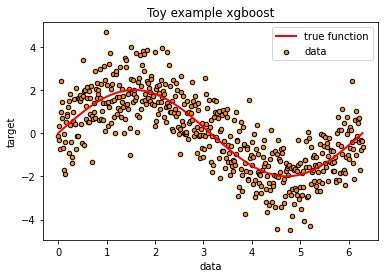

In [ ]:
# Plot the raw data without any model prediction
plot_toy(x, y, m)

Let's have a look at the shape of our feature x and target y.

In [ ]:
print(x.shape)
print(y.shape)

(500,)
(500,)


These are both 1-dimensional arrays. XGBoost needs the input to be a 2-dimensional array, se we need to reshape this array.

In [ ]:
x_2d = x.reshape(-1,1)
print(x_2d.shape)

(500, 1)


### 2.2 XGBoost toy model: step 1

We start our exploration of the XGBoost algorithm by fitting a model with:
* low number of trees
* shallow trees
* very high learning rate

In [ ]:
# fitting model 1
xgb_model1 = xgb.XGBRegressor(n_estimators = 5,
                              objective='reg:squarederror',
                              max_depth = 1,
                              learning_rate = 1)

xgb_model1.fit(x_2d, y)

XGBRegressor(learning_rate=1, max_depth=1, n_estimators=5,
             objective='reg:squarederror')

In [ ]:
# predict model 1
predict_model1 = xgb_model1.predict(x_2d)

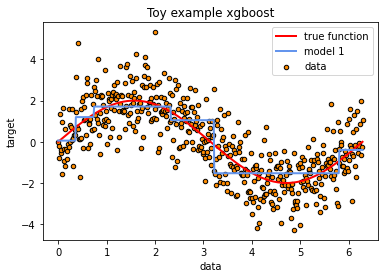

In [ ]:
# Plot the predictions for model 1
plot_toy(x, y, m, predict_model1, "model 1")

### 2.3 XGBoost toy model: step 2

We continue our exploration of the XGBoost algorithm by fitting a model with:
* low number of trees
* shallow trees
* very small learning rate.

In [ ]:
# fitting model 2
xgb_model2 = xgb.XGBRegressor(n_estimators = 5,
                              objective='reg:squarederror',
                              max_depth = 1,
                              learning_rate = 0.1)
xgb_model2.fit(x_2d, y)

XGBRegressor(max_depth=1, n_estimators=5, objective='reg:squarederror')

In [ ]:
# predict model 2
predict_model2 = xgb_model2.predict(x_2d)

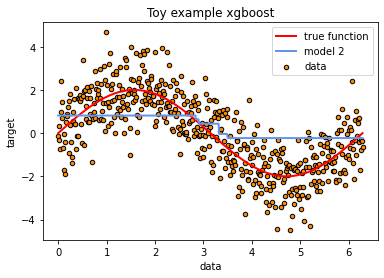

In [ ]:
# Plot the predictions for model1
plot_toy(x, y, m, predict_model2, "model 2")

### 2.4 XGBoost toy model: step 3

Let us now fit a model with:
* high number of trees <span style="color:#173F5F">**(careful considerations wrt overfitting must be done)**</span>
* higher ```max_depth``` parameter compared to the models constructed in step 1 and step 2
* very small learning rate.

In [ ]:
# fitting model 3
xgb_model3 = xgb.XGBRegressor(n_estimators = 300,
                              objective='reg:squarederror',
                              max_depth = 2,
                              learning_rate = 0.01)
xgb_model3.fit(x_2d, y)

XGBRegressor(learning_rate=0.01, max_depth=2, n_estimators=300,
             objective='reg:squarederror')

We can now visiualize the fitting procedure by plotting the predictions at different boosting iterations.

In [ ]:
# generate an array that contains prediction per boosting iteration for model 3
iterations = np.arange(1,299,34)
prediction_per_iteration = np.array([[0.0]*len(iterations)]*x.shape[0])
for i in np.arange(len(iterations)):
    prediction_per_iteration[:,i] = xgb_model3.predict(x.reshape(-1,1), ntree_limit = int(iterations[i]))

print(prediction_per_iteration.shape)
prediction_per_iteration

(500, 9)


array([[ 0.50958866,  0.73592377,  0.72380406, ...,  0.50984818,
         0.46063888,  0.40252906],
       [ 0.50958866,  0.73592377,  0.72380406, ...,  0.50984818,
         0.46063888,  0.40252906],
       [ 0.50958866,  0.73592377,  0.72380406, ...,  0.50984818,
         0.46063888,  0.40252906],
       ...,
       [ 0.49090728,  0.21087366, -0.07815206, ..., -0.45671779,
        -0.43809116, -0.41294008],
       [ 0.49090728,  0.21087366, -0.07815206, ..., -0.45671779,
        -0.43809116, -0.41294008],
       [ 0.49090728,  0.21087366, -0.07815206, ..., -0.45671779,
        -0.43809116, -0.41294008]])

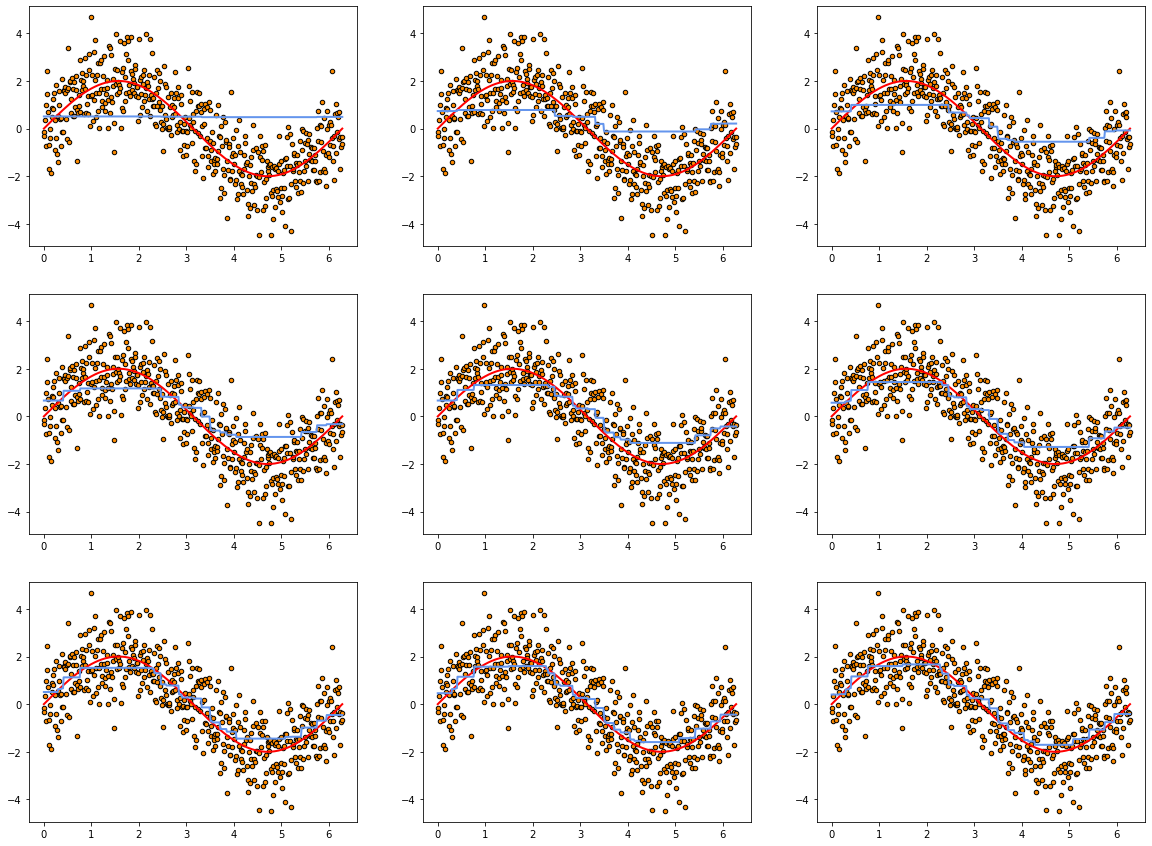

In [ ]:
# plot using incremental number of boosts to improve fitting
seg = int(prediction_per_iteration.shape[1]/3)
fig, ax = plt.subplots(nrows=seg, ncols=seg, figsize=(20, 15))
ax = ax.ravel()
for i in range(prediction_per_iteration.shape[1]):
    ax[i].scatter(x, y, s=20, edgecolor="black", c="darkorange", label="data")
    ax[i].plot(x, m, color="red", label="true function", linewidth=2)
    ax[i].plot(x, prediction_per_iteration[:,i], color="cornflowerblue", label="model 3", linewidth=2)

## 3. Tuning parameters

It has become clear by now that we have a lot of (tuning) parameters at our disposal to <span style="color:#173F5F">**tweak**</span> the GBM.

Some have a <span style="color:#173F5F">**big impact**</span> on the performance and should therefore be <span style="color:#173F5F">**properly tuned**</span>:
* ```n_estimators```: depends very much on the use case, it varies between 100 and 10000
* ```max_depth```: low values are preferred for boosting to obtain weak base learners
* ```learning rate```: typically set the lowest possible value that is computationally feasable.

<span style="color:#173F5F">**Rule of thumb**</span>: if ```learning_rate``` goes down, then ```n_estimators``` goes up.

XGBoost relies on a lot of parameters which can impact performance. A proper tuning procedure is therefore crucial.
We start by separating a train and test set for further use.

### 3.1 Train test split

Tuning parameters should always be picked on a train set and the resulting performance is afterwards evaluated on an out-of-sample test set. Below we perform a typical 80-20 split (train vs. test) by stratifying on the target variable. This makes sure that the distribution of the target in train and test set is similar.

In [ ]:
# Split the data in train and test data
x_train, x_test, y_train, y_test = train_test_split(x_2d, y, test_size = 0.2, random_state = 54321,stratify = pd.cut(y, bins = 10))

In [ ]:
# Print the shape of the full data and train/test components
print(x_2d.shape)
print(x_train.shape)
print(x_test.shape)

(500, 1)
(400, 1)
(100, 1)


### 3.2 Manual grid search example

We first set up a manual grid search to iterate over possible values for the following tuning parameters
* the maximal tree depth
* the learning rate

In [ ]:
# DataFrame to store tuning results
pd_search_manual = pd.DataFrame({'max_depth':[1,1,3,3,5,5,7,7],
                                 'learning_rate':[0.01,0.1,0.01,0.1,0.01,0.1,0.01,0.1],
                                 'MSE':np.inf})
pd_search_manual

,max_depth,learning_rate,MSE
0,1,0.01,inf
1,1,0.10,inf
2,3,0.01,inf
3,3,0.10,inf
4,5,0.01,inf
5,5,0.10,inf
6,7,0.01,inf
7,7,0.10,inf


We now fit each combination of tuning parameters on the train data and evaluate the performance of the fitted model on the test data:

In [ ]:
# fit 8 XGBRegressors manually and retain the performance in the DataFrame
for i in np.arange(pd_search_manual.shape[0]):
    xgb_it = xgb.XGBRegressor(objective='reg:squarederror',
                              n_estimators = 100,
                              booster='gbtree',
                              max_depth = pd_search_manual.loc[i,'max_depth'],
                              learning_rate = pd_search_manual.loc[i,'learning_rate'])
    xgb_it.fit(x_train,y_train)
    y_pred_it = xgb_it.predict(x_test)
    pd_search_manual.loc[i,'MSE'] = mean_squared_error(y_true=y_test, y_pred=y_pred_it)

pd_search_manual.sort_values('MSE')

,max_depth,learning_rate,MSE
1,1,0.10,1.222235
3,3,0.10,1.234072
5,5,0.10,1.346051
6,7,0.01,1.418137
4,5,0.01,1.438008
2,3,0.01,1.462660
7,7,0.10,1.476382
0,1,0.01,1.738995


**Which problem can you spot following this approach?**

### 3.3 Cross-validation with an automatic grid search

We can exploit ```GridSearchCV``` from ```sklearn``` to automate a grid-search operation with cross-validation:
* a set of hyperparameters is required to be defined in a dictionary a priori
* all the combinations of the values defined in the dictionary are passed and evaluatied using Cross-Validation method
* we define a scoring rule to define which is the best parameter combination

In [ ]:
# define dictionary for gridsearch
search_dict = {'max_depth':[1,3,5,7,9],
               'learning_rate':[0.001,0.01,0.1,1]}

# Initialize an XGBRegressor
xgb_grid = xgb.XGBRegressor(objective='reg:squarederror',
                            n_estimators = 100,
                            booster='gbtree')

The method ```sklearn.model_selection.GridSearchCV``` presents the following arguments:

* ```estimator```: pass the model instance for which you want to check the hyperparameters
* ```param_grid```: the dictionary object that holds the hyperparameters you want to try
* ```scoring```: evaluation metric that you want to use, you can simply pass a valid string/object of evaluation metric
* ```n_jobs```: number of processes you wish to run in parallel for this task; if equal to -1 all available processors will be used.
* ```cv```: number of cross-validation you have to try for each selected set of hyperparameters
* ```verbose```: you can set it to 1 to get the detailed print out while you fit the data to GridSearchCV* ...

In [ ]:
# execute cross_validation
xgb_gridsearch = GridSearchCV(estimator=xgb_grid,
                              param_grid=search_dict,
                              scoring='neg_mean_squared_error',
                              return_train_score=False,
                              verbose=1,
                              cv=5)
xgb_gridsearch.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=XGBRegressor(objective='reg:squarederror'),
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1],
                         'max_depth': [1, 3, 5, 7, 9]},
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
pd.DataFrame(xgb_gridsearch.cv_results_).sort_values('rank_test_score')[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,0.011724,0.000080,0.000642,0.000010,0.1,1,"{'learning_rate': 0.1, 'max_depth': 1}",-1.679581,-1.054547,-1.203540,-1.181949,-1.224757,-1.268875,0.213723,1
11,0.016330,0.000866,0.000978,0.000221,0.1,3,"{'learning_rate': 0.1, 'max_depth': 3}",-1.668660,-1.123877,-1.272220,-1.353485,-1.388917,-1.361432,0.178661,2
15,0.012077,0.000348,0.000652,0.000022,1,1,"{'learning_rate': 1, 'max_depth': 1}",-1.631114,-1.173289,-1.349548,-1.318998,-1.399552,-1.374500,0.148773,3
6,0.016030,0.001211,0.000717,0.000023,0.01,3,"{'learning_rate': 0.01, 'max_depth': 3}",-1.914337,-1.307901,-1.314777,-1.474654,-1.641916,-1.530717,0.227574,4
12,0.019827,0.000308,0.001045,0.000068,0.1,5,"{'learning_rate': 0.1, 'max_depth': 5}",-1.914190,-1.271914,-1.441368,-1.517921,-1.635781,-1.556235,0.214457,5


In [ ]:
xgb_gridsearch.best_params_

{'learning_rate': 0.1, 'max_depth': 1}

### 3.4 Randomized search

A grid search has the advantage that all possible combinations of tuning parameters are considered and the optimal combination is found. This procedure however becomes extremely time-consuming if a lot of tuning parameters are involved. In such a situation, a randomized search is better to save computation time. A randomized search simply tries *m* possible combinations out of *n* cases and returns the best performing one from this subset.

The method ```sklearn.model_selection.RandomizedSearchCV``` presents the following additional (or other) parameters:

* ```param_distributions```: the dictionary object that holds the distribution of possible hyperparameters you want to try
* ```n_iter```: the number of random tuning parameter combinations to try out
* ```random_state```: an initializer to make the random selection process repeatable.

In [ ]:
# execute cross_validation
xgb_randomsearch = RandomizedSearchCV(estimator=xgb_grid,
                                      param_distributions=search_dict,
                                      n_iter=10,
                                      scoring='neg_mean_squared_error',
                                      return_train_score=False,
                                      verbose=1,
                                      cv=5,
                                      random_state = 54321)
xgb_randomsearch.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=XGBRegressor(objective='reg:squarederror'),
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1, 1],
                                        'max_depth': [1, 3, 5, 7, 9]},
                   random_state=54321, scoring='neg_mean_squared_error',
                   verbose=1)

The optimal combination of parameters is not within the subset of 10 out of 100 possibilities in our grid:

In [ ]:
pd.DataFrame(xgb_randomsearch.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.015882,0.000656,0.000878,0.000112,3,0.1,"{'max_depth': 3, 'learning_rate': 0.1}",-1.668660,-1.123877,-1.272220,-1.353485,-1.388917,-1.361432,0.178661,1
6,0.013048,0.001674,0.000694,0.000087,1,1,"{'max_depth': 1, 'learning_rate': 1}",-1.631114,-1.173289,-1.349548,-1.318998,-1.399552,-1.374500,0.148773,2
2,0.019638,0.000196,0.000998,0.000014,5,0.1,"{'max_depth': 5, 'learning_rate': 0.1}",-1.914190,-1.271914,-1.441368,-1.517921,-1.635781,-1.556235,0.214457,3
1,0.030232,0.003143,0.001142,0.000041,9,0.01,"{'max_depth': 9, 'learning_rate': 0.01}",-1.997941,-1.394366,-1.350813,-1.729463,-2.004928,-1.695502,0.282085,4
0,0.013431,0.002499,0.000653,0.000028,1,0.01,"{'max_depth': 1, 'learning_rate': 0.01}",-2.250516,-1.547494,-1.575817,-1.733928,-1.803403,-1.782232,0.252895,5
8,0.026523,0.003537,0.001165,0.000023,7,0.1,"{'max_depth': 7, 'learning_rate': 0.1}",-2.176838,-1.440022,-1.682409,-1.844431,-1.835764,-1.795893,0.240245,6
5,0.016596,0.001287,0.000909,0.000161,3,1,"{'max_depth': 3, 'learning_rate': 1}",-2.680865,-1.732931,-1.983423,-2.172457,-2.283173,-2.170570,0.316113,7
9,0.023483,0.001186,0.001123,0.000036,9,1,"{'max_depth': 9, 'learning_rate': 1}",-3.042363,-1.948582,-2.248963,-2.466232,-2.427492,-2.426726,0.357992,8
3,0.015492,0.000280,0.000692,0.000028,3,0.001,"{'max_depth': 3, 'learning_rate': 0.001}",-3.407591,-2.860098,-2.836675,-2.928167,-3.230745,-3.052655,0.226680,9
7,0.023527,0.000437,0.000894,0.000033,7,0.001,"{'max_depth': 7, 'learning_rate': 0.001}",-3.418826,-2.854942,-2.818655,-2.941027,-3.244230,-3.055536,0.235392,10


In [ ]:
xgb_randomsearch.best_params_

{'learning_rate': 0.1, 'max_depth': 3}

## 4. Claim frequency and severity data

We now turn to the modeling of claim frequency and severity data with XGBoost.

### 4.1 Read the MTPL dataset

We first read and pre-process the MTPL data.

In [ ]:
mtpl = pd.read_csv("https://katrienantonio.github.io/hands-on-machine-learning-R-module-1/data/PC_data.txt", delimiter = "\t")
mtpl.columns = mtpl.columns.str.lower()
mtpl = mtpl.rename(columns= {'exp': 'expo'})
print(mtpl.shape)
mtpl.head()

(163231, 18)


,id,nclaims,amount,avg,expo,coverage,fuel,use,fleet,sex,ageph,bm,agec,power,pc,town,long,lat
0,1,1,1618.001036,1618.001036,1.000000,TPL,gasoline,private,N,male,50,5,12,77,1000,BRUSSEL,4.355223,50.845386
1,2,0,0.000000,NaN,1.000000,PO,gasoline,private,N,female,64,5,3,66,1000,BRUSSEL,4.355223,50.845386
2,3,0,0.000000,NaN,1.000000,TPL,diesel,private,N,male,60,0,10,70,1000,BRUSSEL,4.355223,50.845386
3,4,0,0.000000,NaN,1.000000,TPL,gasoline,private,N,male,77,0,15,57,1000,BRUSSEL,4.355223,50.845386
4,5,1,155.974606,155.974606,0.046575,TPL,gasoline,private,N,female,28,9,7,70,1000,BRUSSEL,4.355223,50.845386


We check the data types of all features:

In [ ]:
mtpl.dtypes

id            int64
nclaims       int64
amount      float64
avg         float64
expo        float64
coverage     object
fuel         object
use          object
fleet        object
sex          object
ageph         int64
bm            int64
agec          int64
power         int64
pc            int64
town         object
long        float64
lat         float64
dtype: object

We need to transform the non-numeric features to a numerical format:

In [ ]:
# converting type(str) columns to categorical
cat_feats = ['coverage','fleet','sex','fuel','use']
for feat in cat_feats:
    mtpl[feat] = mtpl[feat].astype('category').cat.codes

In [ ]:
mtpl.dtypes

id            int64
nclaims       int64
amount      float64
avg         float64
expo        float64
coverage       int8
fuel           int8
use            int8
fleet          int8
sex            int8
ageph         int64
bm            int64
agec          int64
power         int64
pc            int64
town         object
long        float64
lat         float64
dtype: object

Let's select some columns to retain as features for model training.

In [ ]:
# cols to retain
feat_cols = ['bm','ageph','agec','power','coverage','fuel','sex','fleet','use']
X_mtpl = mtpl[feat_cols]
X_mtpl

,bm,ageph,agec,power,coverage,fuel,sex,fleet,use
0,5,50,12,77,2,1,1,0,0
1,5,64,3,66,1,1,0,0,0
2,0,60,10,70,2,0,1,0,0
3,0,77,15,57,2,1,1,0,0
4,9,28,7,70,2,1,0,0,0
...,...,...,...,...,...,...,...,...,...
163226,5,37,10,40,2,0,1,0,1
163227,0,44,6,55,2,0,1,0,0
163228,0,50,10,40,2,0,1,0,0
163229,0,43,7,66,2,1,1,0,0


### 4.2 Claim frequency

Let's develop a claim frequency model to predict the number of claims someone is expected to file. The most straightforward way to do so, is by modeling claim frequencies directly and incorporating exposure periods as weights (cfr. the theory session on neural networks in module 1 where a similar modelling strategy was demonstrated).

In [ ]:
# let's calculate claim frequency and weights
y_mtpl_freq = np.array(mtpl.nclaims/mtpl.expo)
w_mtpl_freq = np.array(mtpl.expo)

We now fit an XGBRegressor using the Poisson deviance as loss function and putting a monotonic increasing contraint on the bonus-malus feature.

In [ ]:
xgb_frequency = xgb.XGBRegressor(n_estimators = 500,
                                 objective='count:poisson',
                                 monotone_constraints = (1,0,0,0,0,0,0,0,0),
                                 max_depth = 3,
                                 learning_rate = 0.01,
                                 base_score = np.sum(y_mtpl_freq * w_mtpl_freq)/np.sum(w_mtpl_freq))

xgb_frequency.fit(X_mtpl, y_mtpl_freq, sample_weight=w_mtpl_freq)

XGBRegressor(base_score=0.1393352157253468, learning_rate=0.01,
             monotone_constraints=(1, 0, 0, 0, 0, 0, 0, 0, 0), n_estimators=500,
             objective='count:poisson')

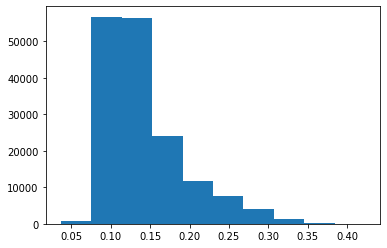

In [ ]:
# prediction on the target scale
pred_on_target_scale = np.round(xgb_frequency.predict(X_mtpl), 5)
plt.hist(pred_on_target_scale, bins=10);

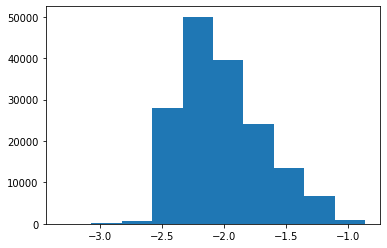

In [ ]:
# prediction on raw log scale
raw_pred_on_log_scale = np.round(xgb_frequency.predict(X_mtpl, output_margin = True), 5)
plt.hist(raw_pred_on_log_scale, bins=10);

We can check if both can be related to each other:

In [ ]:
# prediction on y scala starting from row log scale
pred_on_target_scale_from_raw = np.round(np.exp(xgb_frequency.predict(X_mtpl, output_margin = True)),5)
#checking equality (with tolerance for decimals)
np.isclose(pred_on_target_scale, pred_on_target_scale_from_raw, atol=1e-05, equal_nan=False).all()

True

Another approach to model claim frequencies is by working via the number of claims as target and including exposure as an offset. This can be done via **xgboost.DMatrix** and using the **base_margin** argument.

### 4.3 Claim severity

We can also develop an XGBoost model for claim severity. For this purpose, we only retain these records that filed a claim and use the average claim cost as target and the number of claims as weights.

In [ ]:
# let's get the target and weights for a severity model
mtpl_sev = mtpl[mtpl.avg.notna()]
X_mtpl_sev = mtpl_sev[feat_cols]
y_mtpl_sev = np.array(mtpl_sev.avg)
w_mtpl_sev = np.array(mtpl_sev.nclaims)

For claim severity, we typically work with a right-skewed distribution like for example the gamma distribution.

In [ ]:
xgb_severity = xgb.XGBRegressor(n_estimators = 100,
                                 objective='reg:gamma',
                                 max_depth = 3,
                                 learning_rate = 0.01,
                                 base_score = np.sum(y_mtpl_sev * w_mtpl_sev)/np.sum(w_mtpl_sev))

xgb_severity.fit(X_mtpl_sev, y_mtpl_sev, sample_weight=w_mtpl_sev)

XGBRegressor(base_score=1620.055008489457, learning_rate=0.01,
             objective='reg:gamma')

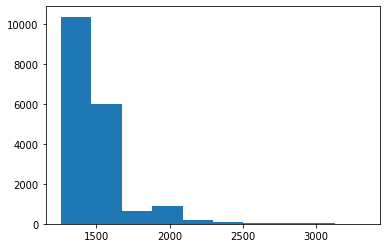

In [ ]:
# prediction on the target scale
pred_on_target_scale_sev = np.round(xgb_severity.predict(X_mtpl_sev), 5)
plt.hist(pred_on_target_scale_sev, bins=10);

## 5. Explainability

An XGBoost model is an ensemble of many trees, and therefore can be described as a **black box** model. There are no observable parameters or coefficients that directly explain the reasoning followed by the model. However, luckily there are many tools available from the explainable artificial intelligence (XAI) field. We will look at a small selection of tools here and dive deeper in this subject in Module 3. Let's continue working with the claim frequency XGBoost model.

### 5.1 Visualizing individual trees

A first possibility is to inspect the individual trees in the ensemble. The first tree in the ensemble (i.e., developed in the first boosting iteration) can be seen as the most important one, trying to capture the general trend in the data. As the boosting iterations increase, the trees start to rectify past mistakes and therefore capture more and more detail.

The code below:
* first gets the booster model
* then takes the first element (or the first tree in the ensemble) and
* finally dumps the result as a collection of strings

In [ ]:
# Print the first tree in the ensemble
xgb_frequency.get_booster().get_dump()[0]

'0:[bm<7] yes=1,no=2,missing=1\n\t1:[bm<2] yes=3,no=4,missing=3\n\t\t3:[ageph<56] yes=7,no=8,missing=7\n\t\t\t7:leaf=-0.00167595968\n\t\t\t8:leaf=-0.00361266197\n\t\t4:[fuel<1] yes=9,no=10,missing=9\n\t\t\t9:leaf=0.00195933296\n\t\t\t10:leaf=-0.000201333838\n\t2:[bm<11] yes=5,no=6,missing=5\n\t\t5:[ageph<27] yes=11,no=12,missing=11\n\t\t\t11:leaf=0.00670837145\n\t\t\t12:leaf=0.00332410773\n\t\t6:[agec<7] yes=13,no=14,missing=13\n\t\t\t13:leaf=0.00681917462\n\t\t\t14:leaf=0.0105548501\n'

Unfortunately, the formatting is not very nice, but we can already see that the **bm** and **ageph** features are used the most. The formatting is improved by writing to a txt file and reading that back into the notebook.

In [ ]:
xgb_frequency.get_booster().dump_model("xgboost_modeldump.txt", with_stats=True)
with open('xgboost_modeldump.txt', 'r') as f:
    txt_xgb = f.read(1500)
print(txt_xgb)

booster[0]:
0:[bm<7] yes=1,no=2,missing=1,gain=1849.69177,cover=20236
	1:[bm<2] yes=3,no=4,missing=3,gain=291.496796,cover=16056.0566
		3:[ageph<56] yes=7,no=8,missing=7,gain=99.8544312,cover=11213.9785
			7:leaf=-0.00167595968,cover=6861.05225
			8:leaf=-0.00361266197,cover=4352.92627
		4:[fuel<1] yes=9,no=10,missing=9,gain=49.8545456,cover=4842.07812
			9:leaf=0.00195933296,cover=1588.55359
			10:leaf=-0.000201333838,cover=3253.52466
	2:[bm<11] yes=5,no=6,missing=5,gain=233.626953,cover=4179.94287
		5:[ageph<27] yes=11,no=12,missing=11,gain=67.2042847,cover=2748.69946
			11:leaf=0.00670837145,cover=667.75885
			12:leaf=0.00332410773,cover=2080.94043
		6:[agec<7] yes=13,no=14,missing=13,gain=45.4702148,cover=1431.24365
			13:leaf=0.00681917462,cover=521.023254
			14:leaf=0.0105548501,cover=910.220459
booster[1]:
0:[bm<7] yes=1,no=2,missing=1,gain=1805.18896,cover=20235.9199
	1:[bm<3] yes=3,no=4,missing=3,gain=286.733185,cover=16031.3311
		3:[ageph<56] yes=7,no=8,missing=7,gain=115.188

It is also possible to summarize the whole XGBoost model in a DataFrame

In [ ]:
# Collect all trees in a pd.DataFrame
xgb_frequency.get_booster().trees_to_dataframe()

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover
0,0,0,0-0,bm,7.0,0-1,0-2,0-1,1849.691770,20236.00000
1,0,1,0-1,bm,2.0,0-3,0-4,0-3,291.496796,16056.05660
2,0,2,0-2,bm,11.0,0-5,0-6,0-5,233.626953,4179.94287
3,0,3,0-3,ageph,56.0,0-7,0-8,0-7,99.854431,11213.97850
4,0,4,0-4,fuel,1.0,0-9,0-10,0-9,49.854546,4842.07812
...,...,...,...,...,...,...,...,...,...,...
7417,499,10,499-10,Leaf,NaN,NaN,NaN,NaN,-0.000106,1166.39709
7418,499,11,499-11,Leaf,NaN,NaN,NaN,NaN,0.000035,1554.65686
7419,499,12,499-12,Leaf,NaN,NaN,NaN,NaN,-0.000359,6167.48486
7420,499,13,499-13,Leaf,NaN,NaN,NaN,NaN,0.000035,4505.63574


Inspecting the trees can be useful, but delivers fairly little information on an aggregate level of the underlying decision process. Let's look at some other tools for this.

### 5.2 Feature importance

A first tool that we will discover is about feature importance: a measure to give insights on how important each feature is in the final model.

This information is stored as an attribute for the XGBoost model:

In [ ]:
# Access the feature importance
xgb_frequency.feature_importances_

array([0.62416416, 0.08494834, 0.04323797, 0.04204111, 0.0411024 ,
       0.07140015, 0.0538618 , 0.02884159, 0.01040248], dtype=float32)

Let's add the feature names to get a better view on each one's importance:

In [ ]:
pd.DataFrame({'feature':X_mtpl.columns.values,
              'importance':xgb_frequency.feature_importances_})

,feature,importance
0,bm,0.624164
1,ageph,0.084948
2,agec,0.043238
3,power,0.042041
4,coverage,0.041102
5,fuel,0.071400
6,sex,0.053862
7,fleet,0.028842
8,use,0.010402


We can also plot these values in descending order of importance:

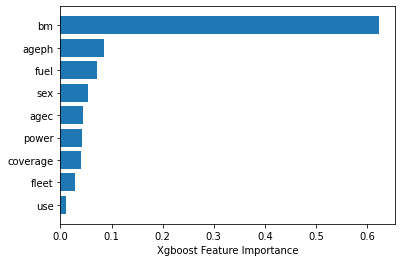

In [ ]:
sorted_idx = xgb_frequency.feature_importances_.argsort()
plt.barh(X_mtpl.columns.values[sorted_idx], xgb_frequency.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance");

Now we know already which features are important in the model, but it would also be interesting to know how each feature relates to the predicted target.

### 5.3 Partial dependence plots

Partial dependence plots (PDPs) capture the marginal relation of a feature (or multiple features) on the predicted target.

The library scikit-learn has a very useful function to directly calculate PDPs from a model object, namely **PartialDependenceDisplay.from_estimator**.

We first need to apply a small hack because otherwise sklearn thinks our XGBoost model is not fitted yet. We need to add a dummy attribute that ends with an underscore.

In [ ]:
from sklearn.utils import validation

validation.check_is_fitted(estimator=xgb_frequency)

NotFittedError: ignored

In [ ]:
xgb_frequency.dummy_ = "dummy"
validation.check_is_fitted(estimator=xgb_frequency)

Now we pass the test and we can generate our PDPs.

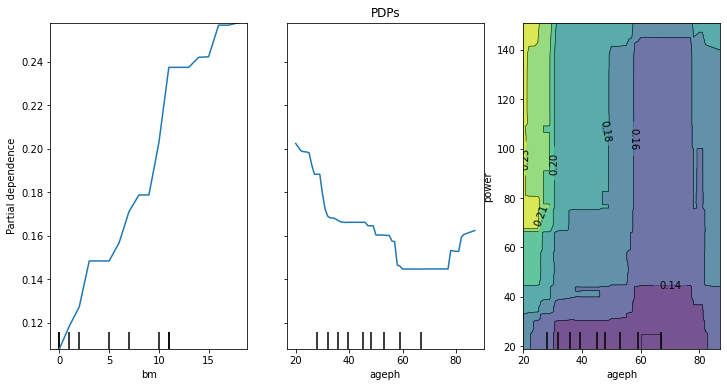

In [ ]:
# PDPs for XGBoost model
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("PDPs")
PartialDependenceDisplay.from_estimator(xgb_frequency, X=X_mtpl[0:1000],features = ['bm','ageph',('ageph','power')], ax=ax);

Feel free to try to generate some other PDPs yourself now.

## 6. Extras

### 6.1. DIY tuning experiment for frequency/severity model

Set up a tuning experiment for a frequency and/or severity XGBoost model on the train data and obtain top performance on the test set.

### 6.2. DIY Tweedie experiment

You can develop a Tweedie XGBoost via **objective=reg:tweedie**. 

There is an extra parameter involved: **tweedie_variance_power**:
* Parameter that controls the variance of the Tweedie distribution 
* default = 1.5
* range: (1,2)
* Set closer to 2 to shift towards a gamma distribution
* Set closer to 1 to shift towards a Poisson distribution.